# Importar dato y eliminar columnas innecesarias

In [124]:
import pandas as pd

In [125]:
bank_churn_csv = pd.read_csv('files/train.csv')
bank_churn_csv

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


In [126]:
bank_churn_csv.shape

(165034, 14)

In [127]:
column: int = bank_churn_csv.columns[0]
bank_churn_csv[column]

0              0
1              1
2              2
3              3
4              4
           ...  
165029    165029
165030    165030
165031    165031
165032    165032
165033    165033
Name: id, Length: 165034, dtype: int64

In [128]:
bank_churn_df = bank_churn_csv.drop(columns=['id', 'CustomerId', 'Surname'])
bank_churn_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


# Transformar datos por columna

In [129]:
# columna CreditScore se pasa a float
bank_churn_df.CreditScore = bank_churn_df.CreditScore.astype(float)
bank_churn_df.CreditScore

0         668.0
1         627.0
2         678.0
3         581.0
4         716.0
          ...  
165029    667.0
165030    792.0
165031    565.0
165032    554.0
165033    850.0
Name: CreditScore, Length: 165034, dtype: float64

In [130]:
bank_churn_df.Geography, unique = bank_churn_df.Geography.factorize(use_na_sentinel=True)
bank_churn_df.Geography = bank_churn_df.Geography.astype(float)
bank_churn_df.Geography

0         0.0
1         0.0
2         0.0
3         0.0
4         1.0
         ... 
165029    1.0
165030    0.0
165031    0.0
165032    1.0
165033    0.0
Name: Geography, Length: 165034, dtype: float64

In [131]:
bank_churn_df.Gender, unique = bank_churn_df.Gender.factorize(use_na_sentinel=True)
bank_churn_df.Gender = bank_churn_df.Gender.astype(float)
bank_churn_df.Gender

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
165029    1.0
165030    0.0
165031    0.0
165032    1.0
165033    0.0
Name: Gender, Length: 165034, dtype: float64

In [132]:
bank_churn_df.Age = bank_churn_df.Age.astype(float)
bank_churn_df.Age

0         33.0
1         33.0
2         40.0
3         34.0
4         33.0
          ... 
165029    33.0
165030    35.0
165031    31.0
165032    30.0
165033    31.0
Name: Age, Length: 165034, dtype: float64

In [133]:
bank_churn_df.Tenure = bank_churn_df.Tenure.astype(float)
bank_churn_df.Tenure

0          3.0
1          1.0
2         10.0
3          2.0
4          5.0
          ... 
165029     2.0
165030     3.0
165031     5.0
165032     7.0
165033     1.0
Name: Tenure, Length: 165034, dtype: float64

In [134]:
bank_churn_df.Balance = bank_churn_df.Balance.astype(float)
bank_churn_df.Balance

0              0.00
1              0.00
2              0.00
3         148882.54
4              0.00
            ...    
165029         0.00
165030         0.00
165031         0.00
165032    161533.00
165033         0.00
Name: Balance, Length: 165034, dtype: float64

In [135]:
bank_churn_df.NumOfProducts = bank_churn_df.NumOfProducts.astype(float)
bank_churn_df.NumOfProducts

0         2.0
1         2.0
2         2.0
3         1.0
4         2.0
         ... 
165029    1.0
165030    1.0
165031    1.0
165032    1.0
165033    1.0
Name: NumOfProducts, Length: 165034, dtype: float64

In [136]:
bank_churn_df.HasCrCard

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
165029    1.0
165030    0.0
165031    1.0
165032    0.0
165033    1.0
Name: HasCrCard, Length: 165034, dtype: float64

In [137]:
bank_churn_df.IsActiveMember.unique()

array([0., 1.])

In [138]:
bank_churn_df.EstimatedSalary

0         181449.97
1          49503.50
2         184866.69
3          84560.88
4          15068.83
            ...    
165029    131834.75
165030    131834.45
165031    127429.56
165032     71173.03
165033     61581.79
Name: EstimatedSalary, Length: 165034, dtype: float64

In [139]:
#bank_churn_df.Exited = bank_churn_df.Exited.astype(float)

In [140]:
from sklearn.model_selection import train_test_split

x_df = bank_churn_df.drop(columns=['Exited'])
y_df = bank_churn_df['Exited']

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42)

In [141]:
# Escalar datos con MinMaxScaler para que estén dentro del rango 0-1 inclusive
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [142]:
# Creacion de tensors
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(data=X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(data=X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset_tensor = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset_tensor = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset_tensor, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset_tensor, batch_size=batch_size)

In [151]:
# Creación de modelo
import torch.nn as nn
class BankChurnModel(nn.Module):
    def __init__(self, input_size):
        super(BankChurnModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x

In [144]:
from torch import optim

input_size: int = X_train.shape[1]
model = BankChurnModel(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [145]:
# Funcion de entrenamiento modelo

def train(model, train_loader, optimizer, criterion, epochs):
    
    loss_list_train = []
    iteration_list_train = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        for index, (batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if (epoch+1) % 10 == 0:
                print('Epoch {}/{}, Loss: {:.4f}'.format(epoch + 1, epochs, loss.item()))
        
        loss_mean = epoch_loss / len(train_loader)
        loss_list_train.append(loss_mean)
        iteration_list_train.append(epoch + 1)
    
    return loss_list_train, iteration_list_train

In [148]:
# Funcion para probar el modelo

def test(model, test_loader, criterion):
    
    model.eval()
    epoch_loss = 0.0
    loss_list_test = []
    iteration_list_test = []
    
    with torch.no_grad():
        for index, (batch_x, batch_y) in enumerate(test_loader):
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            epoch_loss += loss.item()
            
            print('Index {}, Loss: {:.4f}'.format(index + 1, loss.item()))
            
            loss_list_test.append(loss.item())
            iteration_list_test.append(index + 1)
    
    loss_test_mean =epoch_loss / len(test_loader)
    return iteration_list_test, loss_list_test, loss_test_mean

In [152]:
epochs: int = 100
loss_list_train, iteration_list_train = train(model, train_loader, optimizer, criterion, epochs)

Epoch 10/100, Loss: 0.3186
Epoch 10/100, Loss: 0.3455
Epoch 10/100, Loss: 0.3639
Epoch 10/100, Loss: 0.3334
Epoch 10/100, Loss: 0.3417
Epoch 10/100, Loss: 0.2431
Epoch 10/100, Loss: 0.2454
Epoch 10/100, Loss: 0.3101
Epoch 10/100, Loss: 0.3366
Epoch 10/100, Loss: 0.2992
Epoch 10/100, Loss: 0.4479
Epoch 10/100, Loss: 0.3204
Epoch 10/100, Loss: 0.2694
Epoch 10/100, Loss: 0.3433
Epoch 10/100, Loss: 0.2238
Epoch 10/100, Loss: 0.1988
Epoch 10/100, Loss: 0.2700
Epoch 10/100, Loss: 0.5322
Epoch 10/100, Loss: 0.3556
Epoch 10/100, Loss: 0.2883
Epoch 10/100, Loss: 0.2779
Epoch 10/100, Loss: 0.3405
Epoch 10/100, Loss: 0.1676
Epoch 10/100, Loss: 0.3709
Epoch 10/100, Loss: 0.3024
Epoch 10/100, Loss: 0.4727
Epoch 10/100, Loss: 0.2458
Epoch 10/100, Loss: 0.3189
Epoch 10/100, Loss: 0.2275
Epoch 10/100, Loss: 0.3585
Epoch 10/100, Loss: 0.3977
Epoch 10/100, Loss: 0.2629
Epoch 10/100, Loss: 0.2410
Epoch 10/100, Loss: 0.3940
Epoch 10/100, Loss: 0.2219
Epoch 10/100, Loss: 0.2931
Epoch 10/100, Loss: 0.3045
E

Text(0.5, 1.0, 'TEST: Loss curve')

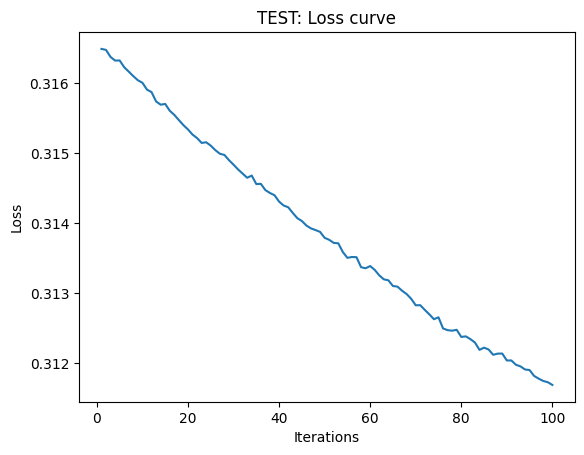

In [153]:
import matplotlib.pyplot as plt

plt.plot(iteration_list_train, loss_list_train)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('TEST: Loss curve')

In [154]:
iteration_list_test, loss_list_test, loss_test_mean = test(model, test_loader, criterion)

Index 1, Loss: 0.3748
Index 2, Loss: 0.3353
Index 3, Loss: 0.2209
Index 4, Loss: 0.3365
Index 5, Loss: 0.4000
Index 6, Loss: 0.3061
Index 7, Loss: 0.3404
Index 8, Loss: 0.2646
Index 9, Loss: 0.4208
Index 10, Loss: 0.4224
Index 11, Loss: 0.1911
Index 12, Loss: 0.3679
Index 13, Loss: 0.2743
Index 14, Loss: 0.2199
Index 15, Loss: 0.2616
Index 16, Loss: 0.3046
Index 17, Loss: 0.3494
Index 18, Loss: 0.3699
Index 19, Loss: 0.2807
Index 20, Loss: 0.4164
Index 21, Loss: 0.5170
Index 22, Loss: 0.3612
Index 23, Loss: 0.3227
Index 24, Loss: 0.2661
Index 25, Loss: 0.3738
Index 26, Loss: 0.2372
Index 27, Loss: 0.3434
Index 28, Loss: 0.3310
Index 29, Loss: 0.2538
Index 30, Loss: 0.2291
Index 31, Loss: 0.2711
Index 32, Loss: 0.2407
Index 33, Loss: 0.3913
Index 34, Loss: 0.3352
Index 35, Loss: 0.3658
Index 36, Loss: 0.3412
Index 37, Loss: 0.2840
Index 38, Loss: 0.2845
Index 39, Loss: 0.3363
Index 40, Loss: 0.2604
Index 41, Loss: 0.3221
Index 42, Loss: 0.2491
Index 43, Loss: 0.3459
Index 44, Loss: 0.30

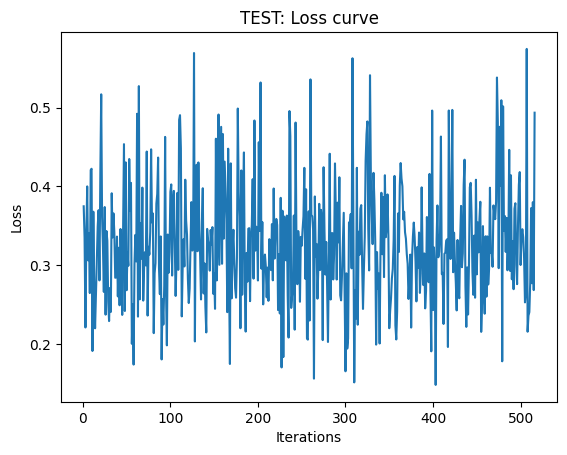

In [155]:
plt.plot(iteration_list_test, loss_list_test)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('TEST: Loss curve')
plt.show()

In [156]:
bank_churn_csv = pd.read_csv('files/test.csv')
bank_churn_csv

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,P'eng,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
110019,275053,15774133,Cox,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
110020,275054,15728456,Ch'iu,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38
110021,275055,15687541,Yegorova,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58


In [157]:
bank_churn_csv.shape

(110023, 13)

In [158]:
bank_churn_df = bank_churn_csv.drop(columns=['id', 'CustomerId', 'Surname'])
bank_churn_df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
...,...,...,...,...,...,...,...,...,...,...
110018,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
110019,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
110020,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38
110021,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58


In [159]:
bank_churn_df.CreditScore = bank_churn_df.CreditScore.astype(float)
bank_churn_df.CreditScore

0         586.0
1         683.0
2         656.0
3         681.0
4         752.0
          ...  
110018    570.0
110019    575.0
110020    712.0
110021    709.0
110022    621.0
Name: CreditScore, Length: 110023, dtype: float64

In [160]:
bank_churn_df.Geography, unique = bank_churn_df.Geography.factorize(use_na_sentinel=True)
bank_churn_df.Geography = bank_churn_df.Geography.astype(float)
bank_churn_df.Geography

0         0.0
1         0.0
2         0.0
3         0.0
4         1.0
         ... 
110018    2.0
110019    0.0
110020    0.0
110021    0.0
110022    0.0
Name: Geography, Length: 110023, dtype: float64

In [161]:
bank_churn_df.Gender, unique = bank_churn_df.Gender.factorize(use_na_sentinel=True)
bank_churn_df.Gender = bank_churn_df.Gender.astype(float)
bank_churn_df.Gender

0         0.0
1         0.0
2         0.0
3         1.0
4         1.0
         ... 
110018    1.0
110019    0.0
110020    1.0
110021    0.0
110022    0.0
Name: Gender, Length: 110023, dtype: float64

In [162]:
bank_churn_df.Age = bank_churn_df.Age.astype(float)
bank_churn_df.Age

0         23.0
1         46.0
2         34.0
3         36.0
4         38.0
          ... 
110018    29.0
110019    36.0
110020    31.0
110021    32.0
110022    37.0
Name: Age, Length: 110023, dtype: float64

In [163]:
bank_churn_df.Tenure = bank_churn_df.Tenure.astype(float)
bank_churn_df.Tenure

0          2.0
1          2.0
2          7.0
3          8.0
4         10.0
          ... 
110018     7.0
110019     4.0
110020     2.0
110021     3.0
110022     7.0
Name: Tenure, Length: 110023, dtype: float64

In [164]:
bank_churn_df.Balance = bank_churn_df.Balance.astype(float)
bank_churn_df.Balance

0              0.00
1              0.00
2              0.00
3              0.00
4         121263.62
            ...    
110018    116099.82
110019    178032.53
110020         0.00
110021         0.00
110022     87848.39
Name: Balance, Length: 110023, dtype: float64

In [165]:
bank_churn_df.NumOfProducts = bank_churn_df.NumOfProducts.astype(float)
bank_churn_df.NumOfProducts

0         2.0
1         1.0
2         2.0
3         1.0
4         1.0
         ... 
110018    1.0
110019    1.0
110020    2.0
110021    1.0
110022    1.0
Name: NumOfProducts, Length: 110023, dtype: float64

In [166]:
bank_churn_df.HasCrCard

0         0.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
110018    1.0
110019    1.0
110020    1.0
110021    1.0
110022    1.0
Name: HasCrCard, Length: 110023, dtype: float64

In [167]:
bank_churn_df.IsActiveMember

0         1.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
110018    1.0
110019    1.0
110020    0.0
110021    1.0
110022    0.0
Name: IsActiveMember, Length: 110023, dtype: float64

In [168]:
bank_churn_df.EstimatedSalary

0         160976.75
1          72549.27
2         138882.09
3         113931.57
4         139431.00
            ...    
110018    148087.62
110019     42181.68
110020     16287.38
110021    158816.58
110022     24210.56
Name: EstimatedSalary, Length: 110023, dtype: float64

In [170]:
test_df = scaler.fit_transform(bank_churn_df)
test_df

array([[0.472     , 0.        , 0.        , ..., 0.        , 1.        ,
        0.80490272],
       [0.666     , 0.        , 0.        , ..., 1.        , 0.        ,
        0.36272309],
       [0.612     , 0.        , 0.        , ..., 1.        , 0.        ,
        0.69441887],
       ...,
       [0.724     , 0.        , 1.        , ..., 1.        , 0.        ,
        0.08138677],
       [0.718     , 0.        , 0.        , ..., 1.        , 1.        ,
        0.79410084],
       [0.542     , 0.        , 0.        , ..., 1.        , 0.        ,
        0.12100646]])

In [171]:
test_df_tensor = torch.tensor(test_df, dtype=torch.float32)

In [172]:
model.eval()
with torch.no_grad():
    predictions = model(test_df_tensor)

In [173]:
predictions = (predictions > 0.5).int()
predictions

tensor([[0],
        [1],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=torch.int32)

In [174]:
result = pd.DataFrame({
    'id': bank_churn_csv.id,
    'Exited': predictions.numpy().flatten()
})

In [175]:
result.to_csv('files/bank_churn_predictions.csv', index=False)

In [176]:
result

,id,Exited
0,165034,0
1,165035,1
2,165036,0
3,165037,0
4,165038,0
...,...,...
110018,275052,0
110019,275053,0
110020,275054,0
110021,275055,0
